From:

- [BERT Fine-Tuning Tutorial with PyTorch · Chris McCormick](http://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [huggingface/pytorch-transformers: 👾 A library of state-of-the-art pretrained models for Natural Language Processing (NLP)](https://github.com/huggingface/pytorch-transformers)


Fine-Tuning:

- Easy Training: recommend 2-4 epochs on a special NLP task
- Less Data
- Good Results

In [31]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import BertForSequenceClassification, BertModel
from pytorch_transformers.optimization import AdamW, WarmupLinearSchedule
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data

```bash
# download glue data
$ git clone https://gist.github.com/60c2bdb54d156a41194446737ce03e2e.git download_glue_repo
$ python download_glue_repo/download_glue_data.py --data_dir='glue_data'
```

In [3]:
# [The Corpus of Linguistic Acceptability (CoLA)](https://nyu-mll.github.io/CoLA/)
data_path = "cola_public/raw/"
train_path = os.path.join(data_path, "in_domain_train.tsv")

In [4]:
df = pd.read_csv(train_path, delimiter='\t', header=None, 
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [5]:
df.sample(5)

,sentence_source,label,label_notes,sentence
668,bc01,1,NaN,I expect John to win and Harry to lose.
7090,sgww85,1,NaN,"Some people go by car, but others by bike."
1997,rhl07,1,NaN,Martha gave Myrna an apple.
4314,ks08,0,*,It tried to rain.
6406,d_98,1,NaN,"We didn't keep a list of the names, but the Pr..."


In [6]:
sentences = df.sentence.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

## Input

In [7]:
# The default download path is ~/.cache
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [8]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [65]:
tokenizer.tokenize("i love you")

['i', 'love', 'you']

In [66]:
tokenizer.vocab_size

30522

Format:

- input ids: index in BERT tokenizer vocabulary
- segment mask: a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences.
- attention mask: a sequence of 1s and 0s, with 1s for input tokens and 0s for padding ones.
- labels: a single 0 or 1

In [9]:
MAX_LEN = 16

In [10]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(s) for s in tokenized_texts],
                         maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# "post" means padding or truncating at the end of the sequence.

In [11]:
attn_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attn_masks.append(seq_mask)

In [12]:
len(attn_masks)

8551

In [13]:
len(input_ids)

8551

In [14]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(
    attn_masks, input_ids, random_state=2018, test_size=0.1)

In [15]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [16]:
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [22]:
train_inputs.shape

torch.Size([7695, 16])

In [23]:
train_labels.shape

torch.Size([7695])

## Model

In [44]:
# need to download the base uncased model, 420M
# The default download path is ~/.cache
model1 = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

In [45]:
model2 = BertModel.from_pretrained("bert-base-uncased", num_labels=2)

In [46]:
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute")).unsqueeze(0)  # Batch size 1
outputs1 = model1(input_ids)
outputs2 = model2(input_ids)

In [47]:
outputs1

(tensor([[0.0587, 0.2715]], grad_fn=<AddmmBackward>),)

In [49]:
encoder_out, text_cls = outputs2

In [51]:
encoder_out.unsqueeze(1)

tensor([[[[-0.0103, -0.1227,  0.3213,  ..., -0.1227,  0.1663,  0.8999],
          [-0.1704,  0.1079,  0.1188,  ...,  0.1253,  0.2631,  0.7764],
          [-0.1531,  0.1066,  0.0684,  ...,  0.2248,  0.2979,  0.8439],
          [-0.2531,  0.1373, -0.2181,  ...,  0.0539,  0.2127,  0.7677],
          [-0.5390, -0.1542,  0.0448,  ...,  0.0955,  0.1294,  0.7215],
          [-0.5359, -0.1256,  0.1278,  ...,  0.1238,  0.3003,  0.3731]]]],
       grad_fn=<UnsqueezeBackward0>)

In [52]:
model1.config

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

In [53]:
model2.config

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

Hyperparamters recommended:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

In [19]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [20]:
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

In [21]:
num_train_optimization_steps = int(len(train_data) / batch_size / 1) * 4

In [22]:
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=100, t_total=num_train_optimization_steps)

## Train

In [23]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
#         batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        scheduler.step()

        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

        print("Train loss: {}".format(tr_loss/nb_tr_steps))


    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
#         batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
          # Forward pass, calculate logit predictions
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

        print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

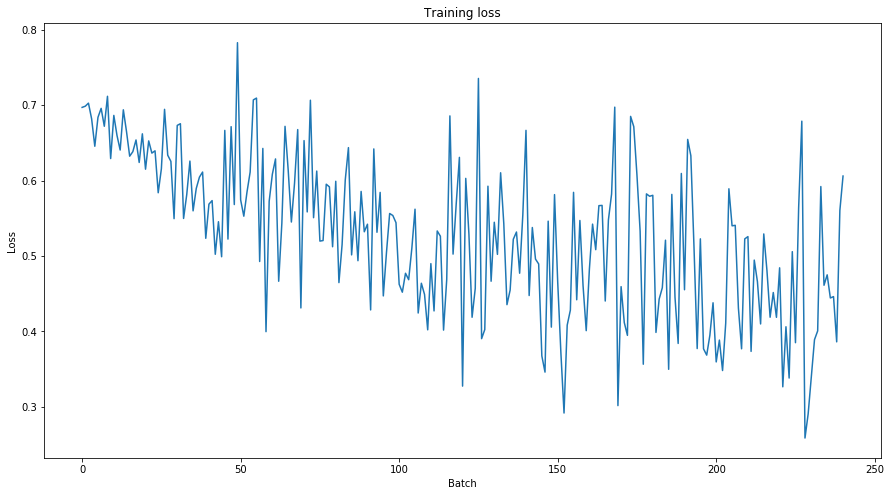

In [28]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()